## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, I will perform A/B tests are very commonly performed by data analysts and data scientists. I will try to understand the result of an A/B test run by an e-commerce website in order to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#reading the file
df0=pd.read_csv('ab_data.csv')
df0.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#Knowing the number of rows and columns
df0.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
#Knowing unique values
df0.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
#computing proportion of users converted.
df0['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

As shown here the total number of times the __new_page__ and __treatment__ don't match will be __3893__.

In [6]:
df0.query('(landing_page == "old_page" and group == "treatment")')['user_id'].count()

1965

In [7]:
df0.query(' (landing_page == "new_page" and group == "control")')['user_id'].count()

1928

f. Do any of the rows have missing values?

There is no missing values.

In [8]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#Creating a dataset and stor it in df2
df_old_one = df0[df0['landing_page'] == 'old_page'][df0['group'] == 'control']
df_new_one = df0[df0['landing_page'] == 'new_page'][df0['group'] == 'treatment']
df2= pd.concat([df_old_one,df_new_one])
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
#knowing unique user_id 
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

As shown here there is just one duplicated user_id.

In [12]:
df2['user_id'].duplicated().sum()

1

Here I tryied to find specific duplicated user-id.

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
# see the duplicated rows
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

I tryied to drop one row with a duplicated user_id by using __timestamp__ value.

In [15]:
drop_row= df2[df2['timestamp'] == '2017-01-14 02:55:59.590927'].index
df2.drop(drop_row , inplace=True)

Here I am trying make sure there is no duplicated user-id.

In [16]:
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page == "new_page"').user_id.nunique()/ df2.user_id.nunique()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**If we see the probability of conversion in general which is 11.9% and the control rate which is 12% and treatment rate whch is 11.8% we can identify that we do not have enough proof to say that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 
$H$0:$p_{new}$ - $p_{old}$ $<$=0

$H$1:$p_{new}$ - $p_{old}$ $> $0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
df2.converted.mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
df2.query('group == "treatment"').user_id.nunique()

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
df2.query('group == "control"').user_id.nunique()

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0,1], p=[1-0.1196, 0.1196],size=145310);

In [26]:
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1], p=[1-0.1196, 0.1196], size=145274);

In [28]:
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.mean()-old_page_converted.mean()

0.00067253842192711855

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=145310, p=[0.1196, 1-0.1196])
    old_page_converted = np.random.choice([0, 1], size=145274, p=[0.1196, 1-0.1196])
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

In [31]:
the_difference= df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

In [32]:
the_difference

-0.0015782389853555567

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5,1,'Histogram of p_diffs')

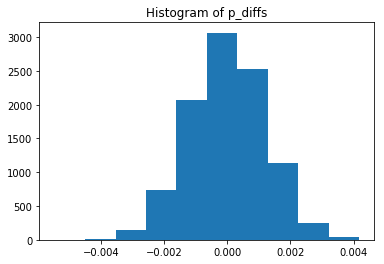

In [33]:
plt.hist(p_diffs);
plt.title('Histogram of p_diffs')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
p_diffs = np.array(p_diffs)

In [35]:
(p_diffs > -0.0015782389853555567).mean()

0.90349999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In this part I computed p_diffs which is higher than the actual difference so because of that we can not reject the null hypothesis which tell us there is no diffence between the old and new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').user_id.nunique()
convert_new = df2.query('group == "treatment" and converted == 1').user_id.nunique()
n_old = df2.query('group == "control"').user_id.nunique()
n_new = df2.query('group == "treatment"').user_id.nunique()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'larger')
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

In [38]:
from scipy.stats import norm

norm.cdf(z_score)

0.90505831275902449

In [39]:
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**We can see z_score is 1.31 and p_value is 0.094. Also we can see here the critical value is 1.64 which is higher than z_score. From this information available to us, we conclude that we can not reject the null hypothesis which says there is no difference between the old and new pages.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [41]:
df2['intercept'] = 1
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [42]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:12:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

__As we can see p-value associated with ab_page is 0.19. And that turns out ab_page is not that important in predicting if individuals will convert or not. Also, the null hypotheses shown there is no difference between the treatment and control group but in alternative hypotheses there will be a difference between the treatment and control group.
Also, It will be different from the value I found in the Part II because of that they maintain different hypothesises
which we can represent them like this:__

__In part II__

H null : Pold >= Pnew

H alternative : Pold < Pnew

__In part III__

H null : Pold = Pnew

H alternative : Pold != Pnew

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**In my opinion it will be good if we add more factor which may facilitate and make my model more accurate and that at the end will lead to depend on my model to make the final decsion but we do not forget more factors mean more complex and more time.**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
all_countries=pd.read_csv('countries.csv')
all_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
df3 = df2.merge(all_countries, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US


In [46]:
df3['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [47]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US,0,0,1
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US,0,0,1


In [48]:
log_model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','US','UK']])
result = log_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        20:12:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [49]:
1/np.exp(-0.0150),np.exp(0.0506),np.exp(0.0408)

(1.0151130646157189, 1.0519020483004984, 1.0416437559600236)

When one unit for ab_page decrease, convertion has 1.5% chance  to happen, while all other varible are constant.

When one unit for UK increases, convertion has almost 5% chance  to happen, while all other varible are constant.

When one unit for US increases, convertion has almost 4% chance  to happen, while all other varible are constant.

For this reason we can not reject the null hypthesis.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [50]:
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']


In [51]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,0,US,0,0,1,0,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,0,US,0,0,1,0,0


In [52]:
logit4 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK_ab_page','CA_ab_page','UK','US']])
result4 = logit4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 24 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:13:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
==============================================================================
"""

In [53]:
np.exp(result4.params)

intercept     0.134794
ab_page       0.979646
UK_ab_page    1.031896
CA_ab_page    0.954198
UK            1.011854
US            1.017682
dtype: float64

By seeing the logistic regression Results, we can identify that the  coefficient of intereaction variable UK_ab_page and US_ab_page are different from the coefficient of ab_page itself. Also, intercept's p-value is less than 0.05, which is statistically enough for converted rate. All other variables are not statistically important. 

Additionally, Z-score for ab_page, UK_ab_page, US_ab_page, UK, US are not large enough to be significant for predicting converted rate. Therefore, the country a user lives is not that important on effecting the converted rate considering the page the user land in. 

When one unit for ab _page decreases, convertion has almost 2% chance to happen, while all other varible are constant.

Convertion is 1.03% chance to happent for UK and ab-page users than CA and ab-page users, while all other varible are constant.

Convertion is 0.95% chance to happent for US and ab-page users than CA and ab-page users, while all other varible are constant.

Convertion is 1.18% chance to happent for the users in UK than CA, while all other varible are constant.

Convertion is 1.75% chance to happent for the users in US than CA, while all other varible are constant.

For this reason we can not reject the null hypthesis.



## Conclusions

In this project I tryied to figher out if the landing page will effect the converted page. Because of that our null hypothesis was there is now difference between the old and new pages, and our hypothesis was that there is difference between the old and new pages.

To do A/B test, I used two method which they are similating from the null and computing the z_score. All of them let me chose the null hypothesis. Also I used  regression model which its result seems like what I got in the A/B test.

At the end I used additional factor in the regression model which is the country to see if the country has hight effect on conversion but the result showed that there is no high effect on converted rate.

In practice, we should consider long-term monitoring of new pages to see if they affect the conversion rate. We must also take into account that if the users of one country will not use the new pages that does not mean the failure of the new pages because these pages may succeed with the users of another country.


Done by Amal Alsubaie